In [1]:
import matplotlib.pyplot as plt
import os
import re
import  shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 6s 0us/step


In [3]:
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'test', 'README', 'train']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_neg.txt',
 'pos',
 'unsup',
 'urls_pos.txt',
 'neg',
 'unsupBow.feat',
 'labeledBow.feat',
 'urls_unsup.txt']

In [5]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


Przygotowanie zbioru recenzji do formaru odpowiedniego do analizy

In [7]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split=0.2,
    subset = 'training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f'Recenzja: {text_batch.numpy()[i]}')
    print(f'Etykieta: {label_batch.numpy()[i]}')

Recenzja: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Etykieta: 0
Recenzja: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [10]:
print(f"Etykieta 0 -> {raw_train_ds.class_names[0]}")
print(f"Etykieta 1 -> {raw_train_ds.class_names[1]}")

Etykieta 0 -> neg
Etykieta 1 -> pos


Przygotowanie zbioru walidacyjnego oraz testowego

In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split=0.2,
    subset = 'validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


Standardyzacja tesktu

In [23]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' %re.escape(string.punctuation),'')

WEKTORYZACJA TESKTU

In [24]:
max_features = 10000
sequence_length = 250


vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [25]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [26]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text), label

In [27]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review,first_label = text_batch[0],label_batch[0]
print(f"Recenzja: {first_review}")
print(f"Etykieta: {first_label}")
print(f"Widok zwektoryzowany: {vectorize_text(first_review,first_label)}")

Recenzja: b"The idea ia a very short film with a lot of information. Interesting, entertaining and leaves the viewer wanting more. The producer has produced a short film of excellent quality that cannot be compared to any other short film that I have seen. I have rated this film at the highest possible rating. I also recommend that it is shown to office managers and business people in any establishment. What comes out of it is the fact that people with ideas are never listened to, their voice is never heard. It is a lesson to be learned by any office that wants to go forward. I hope that the produced will produce a second part to this 'idea'. I look forward to viewing the sequence. Once again congrats to Halaqah media in producing a film of excellence and quality with a lesson in mind."
Etykieta: 1
Widok zwektoryzowany: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   2,  314,    1,    4,   52,  350,   19,   16,    4,  171,    5,
        1574,  217,  424,    3,  874,    2,  

In [30]:
print(f"716 --> {vectorize_layer.get_vocabulary()[716]}")
print(f"1287 --> {vectorize_layer.get_vocabulary()[1287]}")
print(f"313 --> {vectorize_layer.get_vocabulary()[313]}")
print(f"2 --> {vectorize_layer.get_vocabulary()[2]}")
print(f'rozmiar słownika: {len(vectorize_layer.get_vocabulary())}')

716 --> sequence
1287 --> silent
313 --> night
2 --> the
rozmiar słownika: 10000


In [32]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

TWORZENIE MODELU

In [35]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)

])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [36]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [37]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
625/625 [==============================] - 10s 15ms/step - loss: 0.6633 - binary_accuracy: 0.6930 - val_loss: 0.6156 - val_binary_accuracy: 0.7746
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5508 - binary_accuracy: 0.7997 - val_loss: 0.5003 - val_binary_accuracy: 0.8218
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4470 - binary_accuracy: 0.8454 - val_loss: 0.4214 - val_binary_accuracy: 0.8484
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3795 - binary_accuracy: 0.8663 - val_loss: 0.3744 - val_binary_accuracy: 0.8612
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3361 - binary_accuracy: 0.8788 - val_loss: 0.3451 - val_binary_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3061 - binary_accuracy: 0.8890 - val_loss: 0.3258 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 6s 10ms

In [38]:
loss,accuracy = model.evaluate(test_ds)

782/782 [==============================] - 4s 5ms/step - loss: 0.3098 - binary_accuracy: 0.8736


In [39]:
#analiza dokładności oraz strat w czasie

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

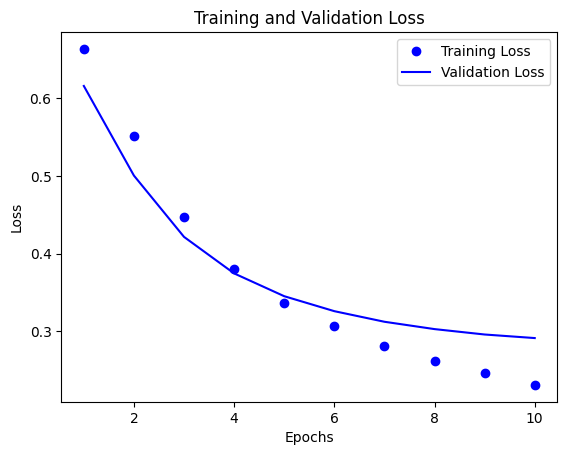

In [42]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

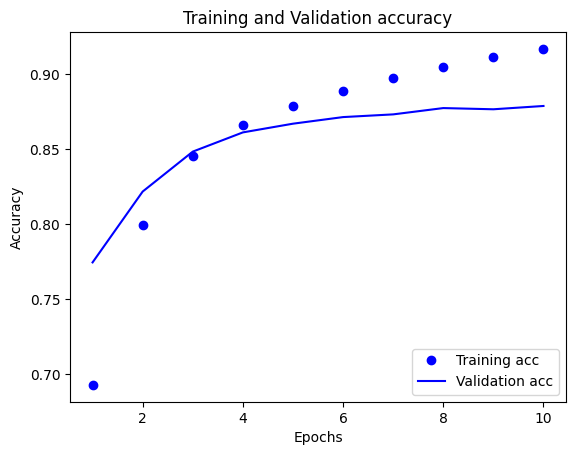

In [43]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")

plt.show()

In [47]:
# Eksportowanie modelu do uniwersalnego użycia na nieprzetworzonych ciągach tekstowych
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

loss,accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)


782/782 [==============================] - 5s 6ms/step - loss: 0.3098 - accuracy: 0.8736
0.8735600113868713


In [58]:
testy = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible...",
    "Very bad movie!",
    "Big shit!",
    "Disaster",
    "Beautiful disaster",
    "Głupi film"
]

In [59]:
export_model.predict(testy)

1/1 [==============================] - 0s 54ms/step


array([[0.6373814 ],
       [0.46288854],
       [0.3790008 ],
       [0.43418267],
       [0.54642326],
       [0.48274603],
       [0.57393163],
       [0.5404068 ]], dtype=float32)